In [1]:
import matplotlib
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D
from tqdm import tqdm
import os
from PIL import Image as im
from pathlib import Path


In [2]:
np.expand_dims(np.asarray([1,2]), axis=0)

array([[1, 2]])

In [2]:
data = np.load('/vol/space/projects/ukbb/projects/silhouette/eids_filtered.npy')


In [3]:
data.shape

(25298,)

In [4]:
DATA_ROOT = "/vol/space/projects/ukbb/projects/silhouette/silhouettes/vat_sat_subjects"
TARGET_ROOT = "/vol/space/projects/ukbb/projects/silhouette/silhouettes/v1"
FEATURES_ROOT = "/vol/space/projects/ukbb/projects/silhouette/ukb668815_imaging.csv"
EXTENSION = ".jpg"
SIZE = (392, 363)
LIMIT = 3000

In [5]:
features = pd.read_csv(FEATURES_ROOT, usecols =["eid", "31-0.0"]).set_index('eid')

In [6]:
arr = np.array([1])

In [7]:
arr[0] == 1 


True

In [8]:
features

,31-0.0
eid,
1000071,0
1000109,0
1000125,1
1000180,1
1000191,1
...,...
6023367,1
6023419,1
6023708,0


In [9]:
features[features.index.isin(np.array([1000071,6023708,6023419]))]

,31-0.0
eid,
1000071,0
6023419,1
6023708,0


In [4]:
def process(DATA_ROOT, LIMIT , TARGET_ROOT, SIZE, EXTENSION):
    COUNT = 0

    for file in tqdm(os.listdir(DATA_ROOT)):
        _path = str(os.path.join(str(DATA_ROOT), file).replace('\\', '/')) +'/body_mask.nii.gz'
        _id = _path[_path[:_path.rfind("/")].rfind("/")+1:_path.rfind("/",0,)]
        
        if (LIMIT > COUNT) :
            if(os.path.exists(_path)):
            
                body_segment = nib.load(_path)
                body_segment_data = body_segment.get_fdata()

                slh_coronal = create_silhouette(body_segment_data, 1)
                slh_sagittal = create_silhouette(body_segment_data, 0)
                concatenated_sil = cat_silhouette(slh_coronal, slh_sagittal, SIZE)

                _target_path =  TARGET_ROOT + "/" + _id + EXTENSION

                concatenated_sil.save(_target_path)

                COUNT += 1
            else:
                continue
        else:
            break

def create_silhouette(body_segment_data: np.ndarray, direction: int) -> np.ndarray:
    tmp = body_segment_data.mean(axis=direction)
    shape = tmp.shape
    oneD_data = np.ravel(tmp)
    slh = []

    for i in range(oneD_data.shape[0]):
        if oneD_data[i] != 0.:
            slh.append(255.)
        else:
            slh.append(0.)   
            
    slh = np.array(slh).reshape(shape)

    if direction == 0: # transpose sagittal slh
        slh = np.asarray(im.fromarray(slh).transpose(im.FLIP_TOP_BOTTOM))

    return slh

def cat_silhouette(slh_coronal: np.ndarray, slh_sagittal: np.ndarray, size: tuple) -> im.Image:
    concatenated_slh = np.concatenate((slh_coronal, slh_sagittal), 0)
    slh_image = im.fromarray(concatenated_slh)

    return slh_image.resize((max(size),max(size))).rotate(90).resize(size).convert('L') 

def read_jpgs(root_path: str):
    ids = []
    imgs = []

    for file in tqdm(os.listdir(root_path)):
        _path = str(os.path.join(str(root_path), file).replace('\\', '/'))
        _id = int(file.replace('.jpg',""))

        img = im.open(_path)

        ids.append(_id)
        imgs.append(np.asarray(img))

    return ids, np.asarray(imgs)

In [20]:
process(DATA_ROOT, LIMIT ,TARGET_ROOT, SIZE)

  0%|          | 0/25299 [00:00<?, ?it/s]/tmp/ipykernel_2176184/4077995118.py:43: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  slh = np.asarray(im.fromarray(slh).transpose(im.FLIP_TOP_BOTTOM))
 12%|█▏        | 3000/25299 [03:43<27:39, 13.44it/s]  


In [5]:
ids, imgs = read_jpgs(TARGET_ROOT)

100%|██████████| 26341/26341 [00:30<00:00, 877.18it/s] 


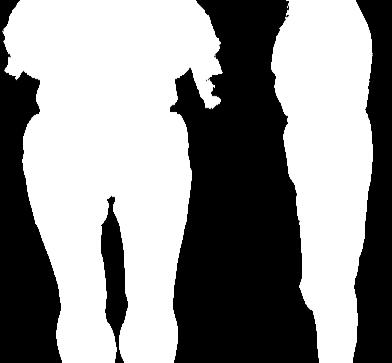

In [6]:
im.fromarray(imgs[0]).show()

In [7]:
imgs.shape

(26341, 363, 392)